# Variational Quantum Linear Solver (VQLS)

The **Variational Quantum Linear Solver (VQLS)** is a hybrid quantum–classical algorithm designed to solve linear systems of equations of the form:

$$
A \cdot x = b
$$

where:

- $A$ is a square (typically Hermitian or symmetric) matrix  
- $b$ is the known vector  
- $x$ is the solution vector we want to obtain  



## Decomposing the Matrix (A)

To run VQLS on a quantum computer, the matrix $A$ must be expressed as a linear combination of unitary matrices:

$$
A = \sum_{n} c_n A_n
$$

where each $A_n$ is a unitary operator and $c_n$ are scalar coefficients.

This decomposition enables efficient evaluation of matrix–vector products on quantum hardware.



## Variational Ansatz

VQLS prepares a **parameterized quantum state** (ansatz):

$$
|\psi(\theta)\rangle = V(\theta) |0\rangle
$$

where:

- $V(\theta)$ is a parameterized quantum circuit  
- $\theta$ is a vector of tunable parameters optimized classically  



## Encoding the Vector \(|b\rangle\)

The known vector \(b\) is encoded using a unitary \(U\):

$$
|b\rangle = U |0\rangle
$$



## Cost Function

The goal of VQLS is to produce an ansatz state \(|\psi(\theta)\rangle\) whose image under $A$ is aligned with the target vector \(|b\rangle\).  
This is achieved by minimizing the cost function:

$$
C(\theta) = 
\langle \psi(\theta) | 
A^\dagger (\mathbb{I} - |b\rangle\langle b|) A 
| \psi(\theta) \rangle
$$

When the cost is minimized, the ansatz approximates the solution vector:

$$
|x\rangle \approx |\psi(\theta^*)\rangle.
$$






## Define System

We will start by defining a system. For purpose of this tutorial we would be solving Ising System

In [1]:
import numpy as np

from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms import optimizers as opt
from qiskit_aer import Aer
from qiskit.primitives import Estimator, Sampler
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

# Import the solver class from the repo
from vqls_prototype.solver.vqls import VQLS
from qiskit.visualization import circuit_drawer

import math
import random
from typing import List, Tuple, Dict
from collections import Counter
from scipy.optimize import minimize
from scipy.sparse import kron, identity, csr_matrix

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Operator, SparsePauliOp, Statevector
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
from qiskit import QuantumCircuit


from vqls_prototype.matrix_decomposition.matrix_decomposition import PauliDecomposition
from vqls_prototype.visualize import *


In [14]:

# Problem parameters
N = 2  # Number of grid points in one dimension

#Ising matrix construction
ising_matrix = construct_ising_matrix(N, J=0, eta=1.0)

print("Ising Matrix:")
print(ising_matrix)

A = ising_matrix

Ising Matrix:
[[0.33333333 0.33333333 0.33333333 0.        ]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.         0.33333333 0.33333333 0.33333333]]


In [15]:
# Create a PauliDecomposition object for matrix A
pauli_decomposer = PauliDecomposition(matrix=A)

coeffs, _, circuits = pauli_decomposer.decompose_matrix()
pauli_strings = pauli_decomposer.strings

print(pauli_decomposer._create_circuit)

100%|██████████| 16/16 [00:00<00:00, 4242.83it/s]

<function PauliDecomposition._create_circuit at 0x2938089a0>


In [16]:
print("\n=== Pauli Decomposition Results ===")
for c, s in zip(coeffs, pauli_strings):
    print(f"{s}: {c}")


=== Pauli Decomposition Results ===
II: (0.3333333333333333+0j)
IX: (0.3333333333333333+0j)
XI: (0.3333333333333333+0j)


In [17]:
# -------------------------------------------------------------
# 5. Pretty printed equation (text)
# -------------------------------------------------------------
def print_pauli_equation(coeffs, strings):
    terms = []
    for c, p in zip(coeffs, strings):
        # Remove tiny imaginary parts
        if abs(c.imag) < 1e-12:
            c = c.real
        terms.append(f"({c})*{p}")
    print("\nA = " + " + ".join(terms))

print_pauli_equation(coeffs, pauli_strings)


A = (0.3333333333333333)*II + (0.3333333333333333)*IX + (0.3333333333333333)*XI


## Ansatz

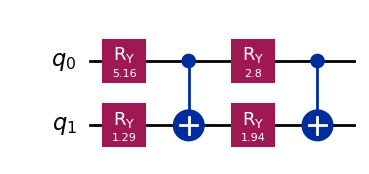

In [18]:


# n = 2
#N is no of qubits
V = hardware_efficient_ansatz_random(N, layers=2)

from qiskit.visualization import circuit_drawer
circuit_drawer(V, output='mpl', filename='beta_circuit.png')


## Hadmard Test to calculate Cost Function

In [19]:
# Example: 4-qubit problem
n = N

V = hardware_efficient_ansatz_random(n, layers=2)
# V = QuantumCircuit(n)
# V.ry(0.5, 0)
# V.rx(1.2, 2)

# U = all Hadamards for intialising b vector
U = QuantumCircuit(n)
for i in range(n):
    U.h(i)


# Pauli strings
Al  = pauli_strings[0]  
Alp = pauli_strings[1]  

print(Al, Alp)

qc_beta  = hadamard_test_beta(V, Al, Alp)
qc_gamma_Al_term = hadamard_test_gamma_Al(V, U, Al, Alp)
qc_gamma_Alp_term = hadamard_test_gamma_Alp(V, U, Al, Alp)
    


II IX


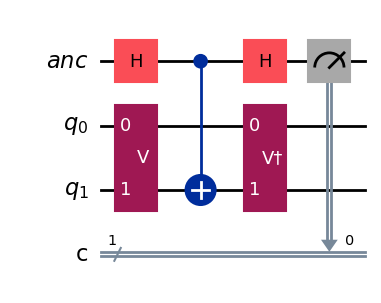

In [20]:
from qiskit.visualization import circuit_drawer

#Visualise Hadmard test circuit 
# circuit_drawer(qc_gamma_Al_term, output='mpl', filename='beta_circuit.png')
circuit_drawer(qc_beta, output='mpl', filename='beta_circuit.png')




## End to End VQLS

In [21]:
# Import the solver class from the repo
from vqls_prototype.solver.vqls import VQLS

# Problem parameters
N = 2  # Number of grid points in one dimension

#Systerm size
system_size = N

#Ising matrix construction
ising_matrix = construct_ising_matrix(N, J=0, eta=1.0)

A = ising_matrix

# Target vector (uniform superposition)
b_vector = np.ones(2**system_size) / np.sqrt(2**system_size)
normalized_b = np.array(b_vector) / np.linalg.norm(b_vector)

# Step 2: Define ansatz (parameterized quantum circuit)
ansatz = hardware_efficient_ansatz_param(N, layers=2)


print("Ising Matrix:\n", ising_matrix)
# Step 3: Choose backend and primitives
backend = Aer.get_backend("statevector_simulator")
estimator = Estimator()
sampler = Sampler()

# Step 4: Choose classical optimizer
optimizer = opt.COBYLA(maxiter=100)

# Step 5: Create and run the VQLS solver
vqls = VQLS(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    sampler=sampler,
    options={
        "matrix_decomposition": "symmetric",  # default
        "use_local_cost_function": False,     # global cost
        "use_overlap_test": False,            # standard Hadamard test
        "verbose": True
    }
)

# Solve Ax = b
result = vqls.solve(ising_matrix, normalized_b)


Ising Matrix:
 [[0.33333333 0.33333333 0.33333333 0.        ]
 [0.33333333 0.33333333 0.         0.33333333]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.         0.33333333 0.33333333 0.33333333]]


/var/folders/m0/98wc8z1s20g0f2k4zvkn7ypr0000gn/T/ipykernel_70314/1088994384.py:26: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
/var/folders/m0/98wc8z1s20g0f2k4zvkn7ypr0000gn/T/ipykernel_70314/1088994384.py:27: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


## Post process the x quantum vector

Quantum solution (rescaled): [-0.49996019 -0.49999194 -0.50003512 -0.50001275]
Classical: [0.5 0.5 0.5 0.5]
Fidelity between quantum and classical solution: 0.9999999969545295


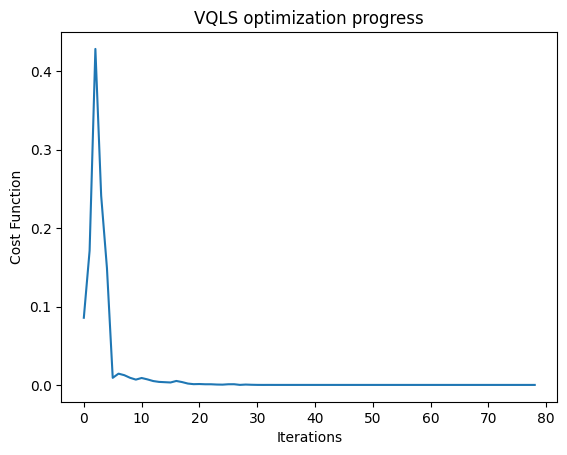

In [22]:
x_quantum = np.real(Statevector(result.state).data)

unnormalization_factor = 1 / np.sqrt(np.real(np.conj(x_quantum).T @ (ising_matrix.T.conj() @ (ising_matrix @ x_quantum))))
x_unnormalized = unnormalization_factor * x_quantum

# Now compare with the true classical solution
x_classical = np.linalg.solve(ising_matrix, normalized_b)
print("Quantum solution (rescaled):", x_unnormalized)
print("Classical:", x_classical)
x_classical /= np.linalg.norm(x_classical)
print("Fidelity between quantum and classical solution:", np.abs(np.dot(np.conj(x_quantum), x_classical))**2)

# Step 7: Optional plotting (if you logged cost)

if hasattr(vqls, "logger"):
    plt.plot(vqls.logger.values)
    plt.xlabel("Iterations")
    plt.ylabel("Cost Function")
    plt.title("VQLS optimization progress")
    plt.show()